# Thyroid Cancer Prediction 

In [7]:
# Step 1: Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import shap
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE



In [8]:
# Step 2: Load the dataset
df = pd.read_csv(r'C:\Users\nikit\Downloads\thyroid_cancer_prediction_dataset.csv')



In [9]:
# Step 3: Add synthetic column for Lymph Node Involvement
df["Lymph_Node_Involvement"] = df["Thyroid_Cancer"].apply(lambda x: np.random.choice(["Yes", "No"], p=[0.6, 0.4]) if x else "No")



In [10]:
# Step 4: Create a new column for Cancer Stage
def assign_stage(row):
    if row["Thyroid_Cancer"] == 0:
        return "No Cancer"
    elif row["Ultrasound_Nodule_Size_cm"] <= 2 and row["PET_Scan"] == "No":
        return "Stage I"
    elif row["Ultrasound_Nodule_Size_cm"] <= 4 and row["Lymph_Node_Involvement"] == "No":
        return "Stage II"
    elif row["Lymph_Node_Involvement"] == "Yes":
        return "Stage III"
    else:
        return "Stage IV"
df["Cancer_Stage"] = df.apply(assign_stage, axis=1)



In [11]:
# Step 5: Encode categorical features
le = LabelEncoder()
for col in df.select_dtypes(include="object").columns:
    df[col] = le.fit_transform(df[col])



In [12]:
# Step 6: EDA - Check for missing values
print(df.isnull().sum())



Age                          0
Gender                       0
Family_History               0
Radiation_Exposure           0
Iodine_Deficiency            0
Neck_Swelling                0
Hoarseness                   0
Difficulty_Swallowing        0
Weight_Loss                  0
Fatigue                      0
Palpitations                 0
Thyroid_Cancer               0
TSH                          0
Free_T4                      0
Thyroglobulin                0
TgAb                         0
Calcium                      0
Ultrasound_Nodule_Size_cm    0
PET_Scan                     0
Microcalcifications          0
Lymph_Node_Involvement       0
Cancer_Stage                 0
dtype: int64


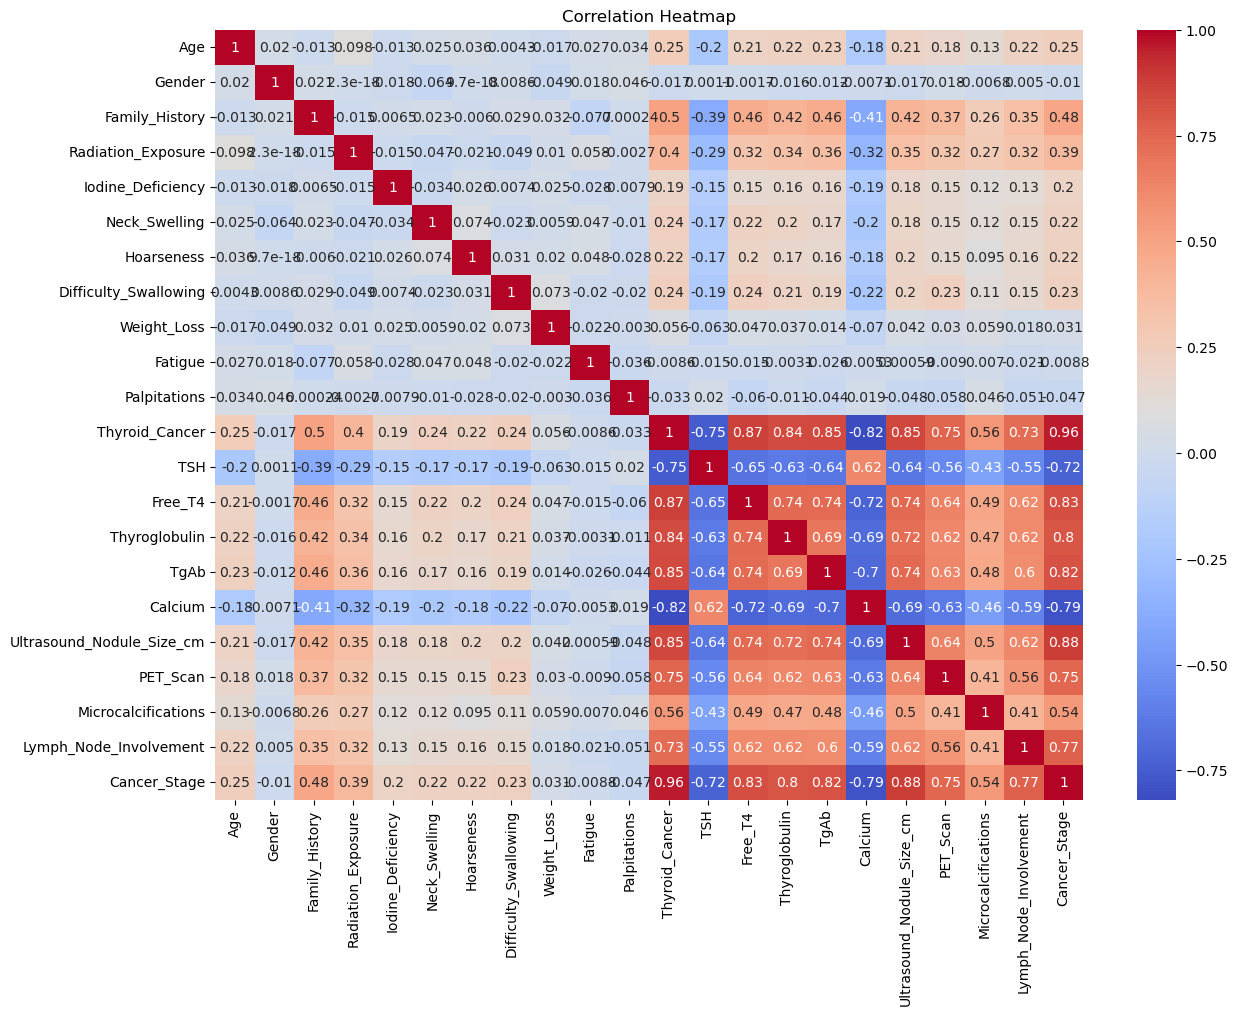

In [13]:
# Step 7: EDA - Plot correlation matrix
plt.figure(figsize=(14, 10))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()



In [14]:
# Step 8: Separate features and targets
X = df.drop(["Thyroid_Cancer", "Cancer_Stage"], axis=1)
y_binary = df["Thyroid_Cancer"]
y_stage = df["Cancer_Stage"]



In [15]:
# Step 9: Balance the binary target using SMOTE
sm = SMOTE(random_state=42)
X_res, y_binary_res = sm.fit_resample(X, y_binary)



In [16]:
# Step 10: Split binary data
X_train, X_test, y_train, y_test = train_test_split(X_res, y_binary_res, test_size=0.2, random_state=42)



In [17]:
# Step 11: Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



In [18]:
# Step 12: Train binary classification model
model = RandomForestClassifier(random_state=42)
model.fit(X_train_scaled, y_train)



RandomForestClassifier(random_state=42)

In [19]:
# Step 13: Predict on test set
y_pred = model.predict(X_test_scaled)




In [20]:
# Step 14: Evaluate performance
print("Binary Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))



Binary Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       129
           1       1.00      1.00      1.00       144

    accuracy                           1.00       273
   macro avg       1.00      1.00      1.00       273
weighted avg       1.00      1.00      1.00       273

Confusion Matrix:
[[129   0]
 [  0 144]]


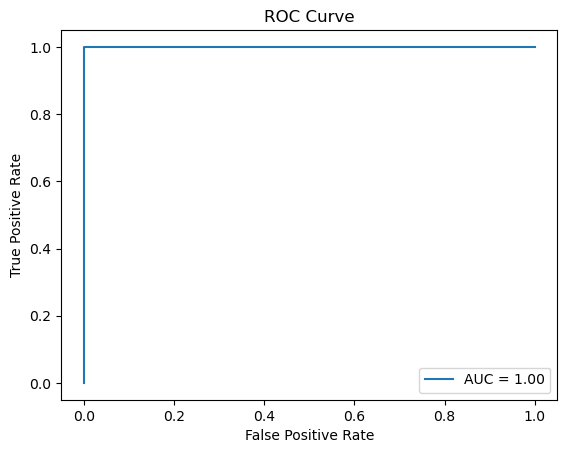

In [21]:
# Step 15: ROC Curve
roc_auc = roc_auc_score(y_test, model.predict_proba(X_test_scaled)[:, 1])
fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test_scaled)[:, 1])
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()



<Figure size 640x480 with 0 Axes>

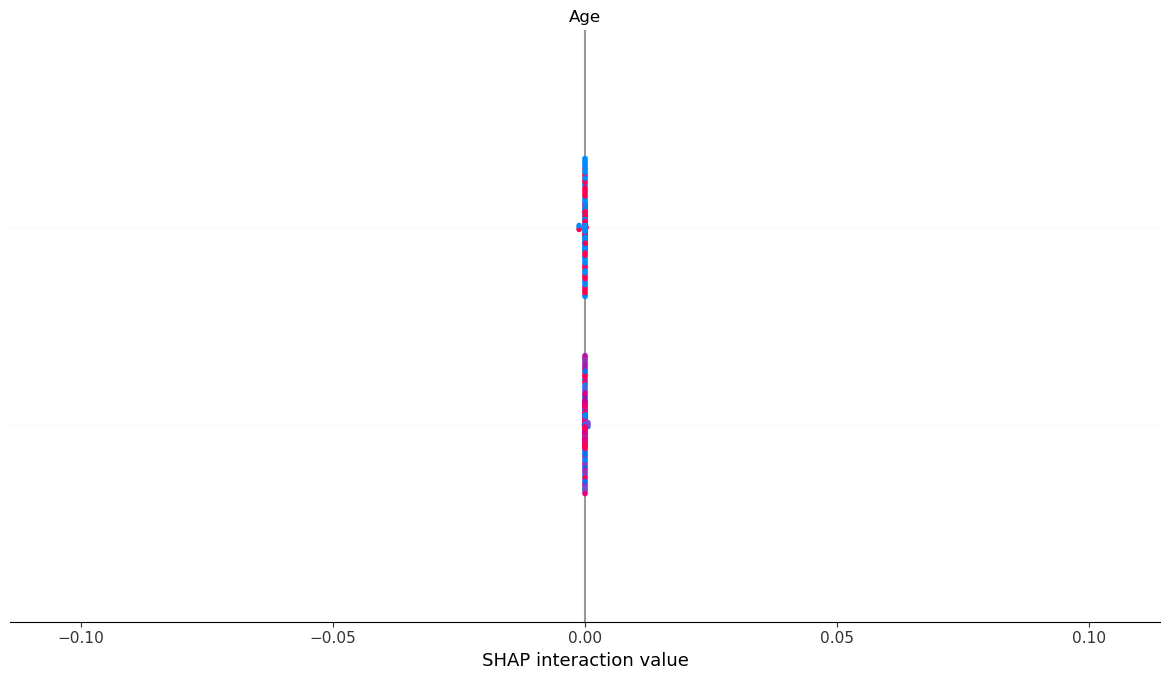

In [22]:
# Step 16: SHAP Explainability
explainer = shap.Explainer(model, X_train_scaled)
shap_values = explainer(X_test_scaled[:100])
shap.summary_plot(shap_values, X_test[:100], feature_names=X.columns)



In [23]:
# Step 17: Hyperparameter tuning
params = {"n_estimators": [100, 150], "max_depth": [10, None], "min_samples_split": [2, 5]}
grid = GridSearchCV(model, params, cv=3, scoring="f1")
grid.fit(X_train_scaled, y_train)
best_model = grid.best_estimator_



In [24]:
# Step 18: Retrain best model
best_model.fit(X_train_scaled, y_train)



RandomForestClassifier(max_depth=10, random_state=42)

In [25]:
# Step 19: Evaluate best model
print("Tuned Model Report:")
print(classification_report(y_test, best_model.predict(X_test_scaled)))



Tuned Model Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       129
           1       1.00      1.00      1.00       144

    accuracy                           1.00       273
   macro avg       1.00      1.00      1.00       273
weighted avg       1.00      1.00      1.00       273



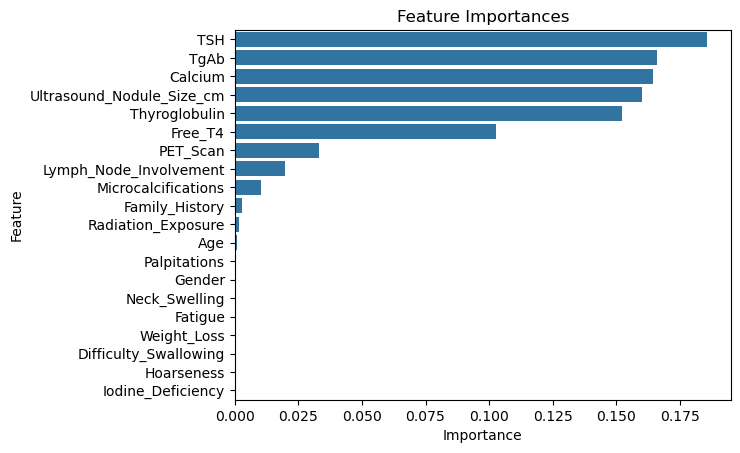

In [26]:
# Step 20: Feature Importance
importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': best_model.feature_importances_
}).sort_values(by='Importance', ascending=False)
sns.barplot(x='Importance', y='Feature', data=importances)
plt.title("Feature Importances")
plt.show()



In [27]:
# Step 21: Save binary model
with open("thyroid_cancer_detection_model.pkl", "wb") as f:
    pickle.dump(best_model, f)



In [28]:
# Step 22: Stage Classification - Use only cancer cases
stage_data = df[df["Thyroid_Cancer"] == 1]
X_stage = stage_data.drop(["Thyroid_Cancer", "Cancer_Stage"], axis=1)
y_stage_final = stage_data["Cancer_Stage"]



In [29]:
# Step 23: Train-test split for stage
X_s_train, X_s_test, y_s_train, y_s_test = train_test_split(X_stage, y_stage_final, test_size=0.2, random_state=42)



In [30]:
# Step 24: Scale stage data
X_s_train_scaled = scaler.fit_transform(X_s_train)
X_s_test_scaled = scaler.transform(X_s_test)



In [31]:
# Step 25: Train model for stage
stage_model = RandomForestClassifier(random_state=42)
stage_model.fit(X_s_train_scaled, y_s_train)



RandomForestClassifier(random_state=42)

Cancer Stage Classification Report:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         1
           2       0.85      1.00      0.92        11
           3       1.00      1.00      1.00        44
           4       1.00      0.88      0.93         8

    accuracy                           0.97        64
   macro avg       0.71      0.72      0.71        64
weighted avg       0.96      0.97      0.96        64



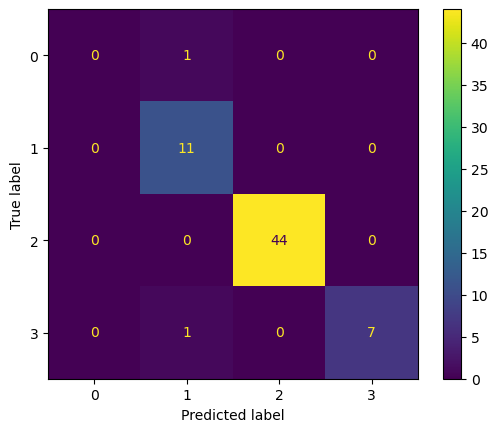

In [32]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Step 26: Evaluate stage model
print("Cancer Stage Classification Report:")
print(classification_report(
    y_s_test,
    stage_model.predict(X_s_test_scaled),
    zero_division=0  # Avoid warning for undefined precision
))

# Optional: Plot confusion matrix for better insight
cm = confusion_matrix(y_s_test, stage_model.predict(X_s_test_scaled))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()


In [33]:
# Step 27: Save stage model
with open("thyroid_cancer_stage_model.pkl", "wb") as f:
    pickle.dump(stage_model, f)